In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from shapely.geometry import Point
import sys
import adjustText as aT
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
ems_calls = 'https://data.cityofnewyork.us/resource/66ae-7zpy.csv?$query=SELECT%20policeprecinct,%20date_extract_y(first_activation_datetime)%20AS%20year,%20count(cad_incident_id)%20AS%20calls%20GROUP%20BY%20policeprecinct,%20date_extract_y(first_activation_datetime)%20LIMIT%2050000'

In [3]:
print(ems_calls)

https://data.cityofnewyork.us/resource/66ae-7zpy.csv?$query=SELECT%20policeprecinct,%20date_extract_y(first_activation_datetime)%20AS%20year,%20count(cad_incident_id)%20AS%20calls%20GROUP%20BY%20policeprecinct,%20date_extract_y(first_activation_datetime)%20LIMIT%2050000


In [4]:
ems = pd.read_csv(ems_calls)

In [5]:
ems.shape

(476, 3)

In [6]:
os.getcwd()

'/nfshome/mrn291/patrol_allocation'

In [7]:
ems.dropna(axis=0, how='any',inplace=True)

In [8]:
ems.year = ems.year.astype(int)
ems.policeprecinct = ems.policeprecinct.astype(int)

In [9]:
ems.dtypes

calls             int64
policeprecinct    int64
year              int64
dtype: object

In [10]:
year_denom = ems.groupby(['year'])[['calls']].sum().reset_index()

In [11]:
ems = ems.merge(year_denom, left_on='year', right_on='year')

In [12]:
ems['share'] = ems.calls_x / ems.calls_y.astype(float)

In [13]:
ems.head()

,calls_x,policeprecinct,year,calls_y,share
0,14037,1,2013,1269484,0.011057
1,12761,5,2013,1269484,0.010052
2,9454,6,2013,1269484,0.007447
3,10935,7,2013,1269484,0.008614
4,17220,9,2013,1269484,0.013565


In [14]:
precincts = gpd.read_file('Police Precincts.geojson')
precincts.precinct = precincts.precinct.astype(int)
precincts.head()


,precinct,shape_area,shape_leng,geometry
0,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...
1,5,18088797.9526,18676.1242594,(POLYGON ((-73.98863862848766 40.7229337202636...
2,6,22098189.8026,26402.9006691,(POLYGON ((-73.99968392160721 40.7385522486597...
3,71,45331787.1744,29978.0942611,(POLYGON ((-73.92854313809303 40.6645732858473...
4,72,104621257.743,87968.1945199,(POLYGON ((-73.99840899113158 40.6718687230323...


In [15]:
precincts.dtypes

precinct       int64
shape_area    object
shape_leng    object
geometry      object
dtype: object

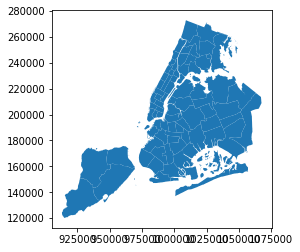

In [16]:
precincts.to_crs(epsg=2263).plot()

In [17]:
ems = precincts.merge(ems, left_on='precinct', right_on='policeprecinct')

In [18]:
ems.head()

,precinct,shape_area,shape_leng,geometry,calls_x,policeprecinct,year,calls_y,share
0,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...,14037,1,2013,1269484,0.011057
1,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...,15856,1,2014,1312541,0.012080
2,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...,15711,1,2015,1378912,0.011394
3,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...,14709,1,2016,1418714,0.010368
4,1,47301761.2426,80586.1546155,(POLYGON ((-74.0438776157395 40.69018767637665...,16212,1,2017,1439846,0.011260


In [19]:
total_patrol_officers = 20000

In [20]:
ems['officers'] = round(ems.share * total_patrol_officers)

In [29]:
ems[ems['precinct']==75]

,precinct,shape_area,shape_leng,geometry,calls_x,policeprecinct,year,calls_y,share,officers
133,75,183100917.807,114009.988899,(POLYGON ((-73.8502309076287 40.62332082362204...,43798,75,2013,1269484,0.034501,690.0
134,75,183100917.807,114009.988899,(POLYGON ((-73.8502309076287 40.62332082362204...,43580,75,2014,1312541,0.033203,664.0
135,75,183100917.807,114009.988899,(POLYGON ((-73.8502309076287 40.62332082362204...,45213,75,2015,1378912,0.032789,656.0
136,75,183100917.807,114009.988899,(POLYGON ((-73.8502309076287 40.62332082362204...,46612,75,2016,1418714,0.032855,657.0
137,75,183100917.807,114009.988899,(POLYGON ((-73.8502309076287 40.62332082362204...,46832,75,2017,1439846,0.032526,651.0


In [22]:
precincts['center'] = precincts['geometry'].to_crs(epsg=2263).centroid
precinct_points = precincts.copy()
precinct_points.set_geometry("center", inplace=True)

In [23]:
ems.dtypes

precinct            int64
shape_area         object
shape_leng         object
geometry           object
calls_x             int64
policeprecinct      int64
year                int64
calls_y             int64
share             float64
officers          float64
dtype: object

In [24]:
years = [2013,2014,2015,2016,2017]

In [25]:
os.chdir('/nfshome/mrn291/patrol_allocation/images')

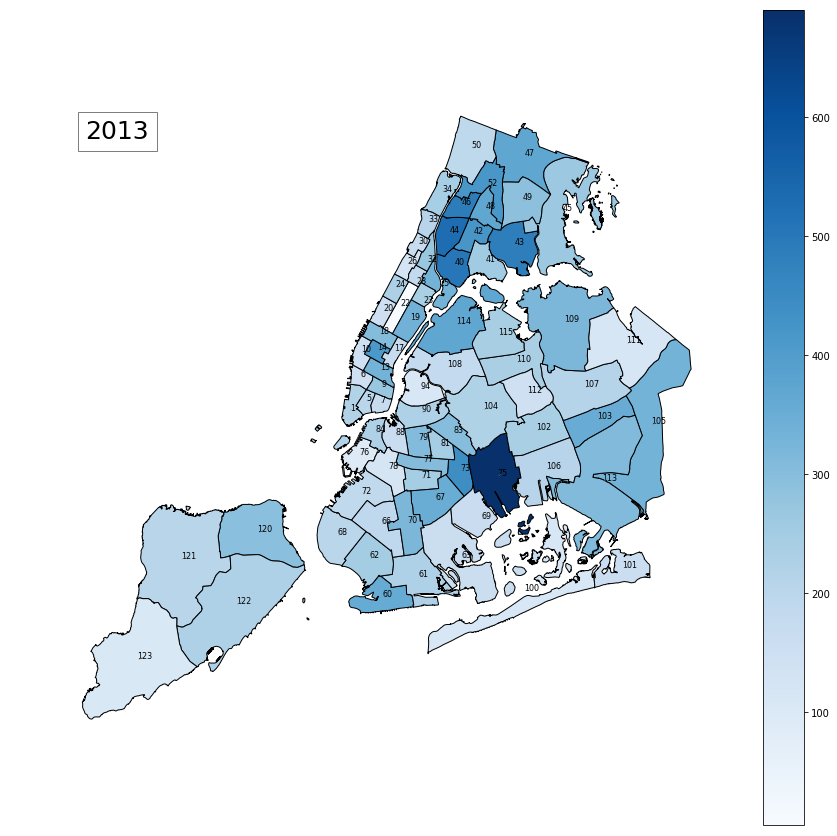

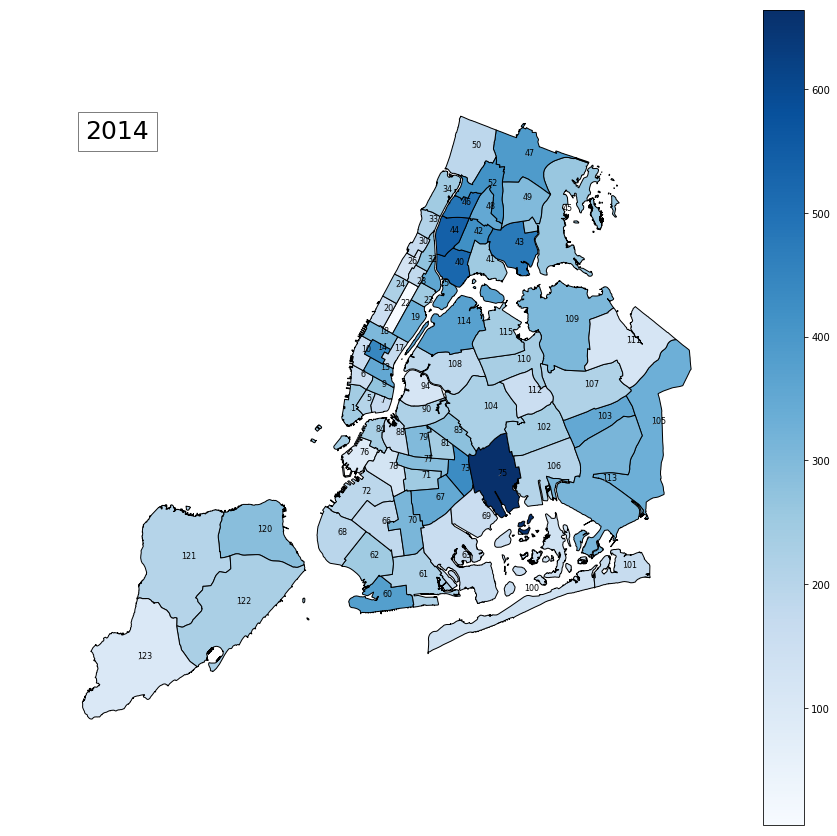

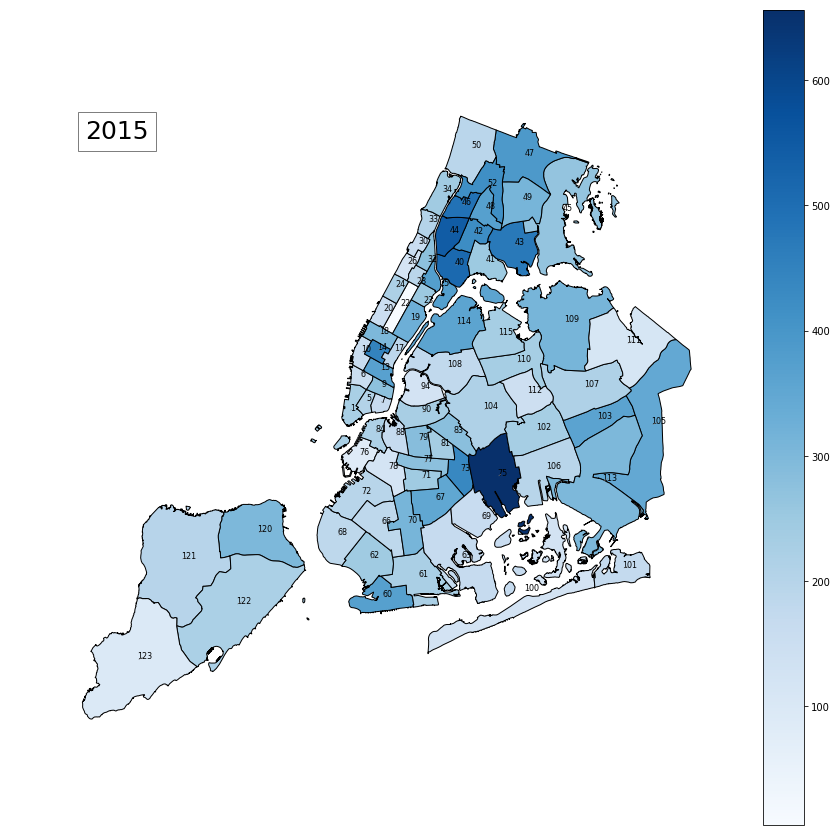

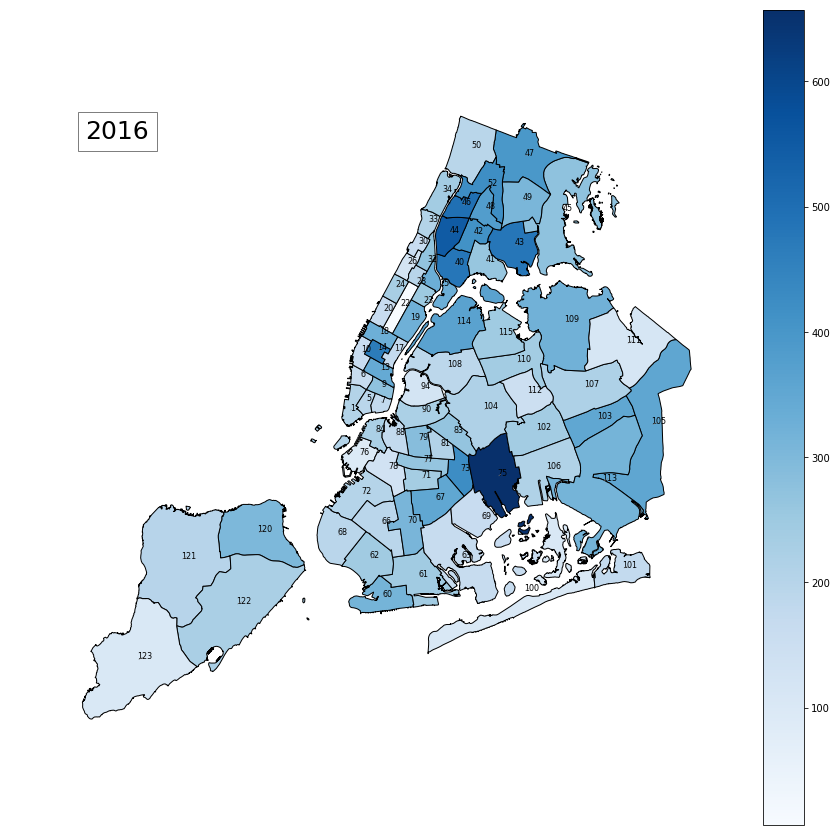

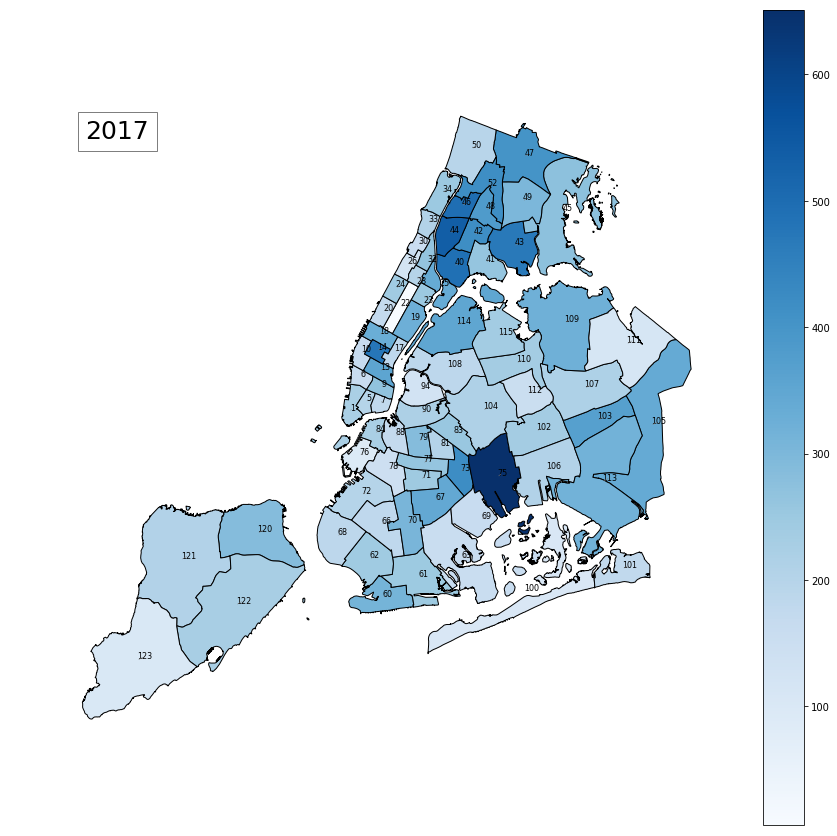

In [27]:
for year in years:
    
    dataset = ems[ems['year']== year]
    fig, ax = plt.subplots(figsize=(15,15))
    texts = []
    ax.set_aspect('equal')
    ax.axis('off')
    #plt.title("2014 Client Share")
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='square', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, year, transform=ax.transAxes, fontsize=25,
        verticalalignment='top', bbox=props)
    dataset.to_crs(epsg=2263).plot(ax=ax, cmap='Blues', column='officers', edgecolor='black', lw=1, legend=True)
    texts = []
    for x,y, label in zip(precinct_points.geometry.x, precinct_points.geometry.y, precinct_points['precinct']):
        texts.append(plt.text(x, y, label, fontsize=8))
    
    aT.adjust_text(texts, force_points=0.3, force_text=0.8, expand_points=(1,1), expand_text=(1,1), 
               arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))
        
    plt.show()
    fig.savefig(str(year)+str("_deployment.png"), bbox_inches='tight')
    